# Setup

## Imports

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split,  TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import numpy as np
import optuna
import xgboost as xgb
from catboost import CatBoostRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt

## Methods

In [24]:

def train_model(model_class, model_params, X_train, y_train):
    # Initialize the model
    model = model_class(**model_params)
    
    # Train the model
    model.fit(X_train, y_train)
    
    return model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(y_true, y_pred, metric, custom_metric=None):
    if metric == 'rmse':
        mse = mean_squared_error(y_true, y_pred)
        return mse ** 0.5
    elif metric == 'mae':
        return mean_absolute_error(y_true, y_pred)
    elif metric == 'r2':
        return r2_score(y_true, y_pred)
    elif metric == 'custom' and custom_metric is not None:
        return custom_metric(y_true, y_pred)
    else:
        raise ValueError("Unsupported metric. Choose from 'rmse', 'mae', 'r2', or use 'custom' with a custom_metric function.")


def hyperparameter_tuning(model_class, param_grid, X_train, y_train, method='grid', n_iter=100, n_trials=100, custom_metric=None):
    """
    Function to perform hyperparameter tuning using GridSearchCV, RandomizedSearchCV, or Bayesian Optimization.
    
    Parameters:
        model_class: The model class to be used (e.g., xgb.XGBRegressor).
        param_grid: The parameter grid or distributions for hyperparameter tuning.
        X_train: Training features.
        y_train: Training labels.
        method: The optimization method to use ('grid', 'random', 'bayesian').
        n_iter: Number of iterations for RandomizedSearchCV (default is 100).
        n_trials: Number of trials for Bayesian Optimization (default is 100).
        custom_metric: Custom metric function for evaluation.
        
    Returns:
        best_model: The best model found by the optimization method.
        best_params: The best hyperparameters found by the optimization method.
    """
    
    def scoring_func(y_true, y_pred):
        return custom_metric(y_true, y_pred)
    
    if method == 'grid':
        print("Using GridSearchCV for hyperparameter tuning...")
        tscv = TimeSeriesSplit(n_splits=5)
        grid_search = GridSearchCV(estimator=model_class(),
                                   param_grid=param_grid,
                                   cv=tscv,
                                   scoring=scoring_func,
                                   verbose=1,
                                   n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
    
    elif method == 'random':
        print("Using RandomizedSearchCV for hyperparameter tuning...")
        tscv = TimeSeriesSplit(n_splits=5)
        random_search = RandomizedSearchCV(estimator=model_class(),
                                           param_distributions=param_grid,
                                           n_iter=n_iter,
                                           cv=tscv,
                                           scoring=scoring_func,
                                           verbose=1,
                                           n_jobs=-1,
                                           random_state=42)
        random_search.fit(X_train, y_train)
        best_model = random_search.best_estimator_
        best_params = random_search.best_params_
    
    elif method == 'bayesian':
        print("Using Bayesian Optimization for hyperparameter tuning...")
        
        def objective(trial):
            # Define the hyperparameters to tune
            param = {key: trial.suggest_uniform(key, *value) if isinstance(value, tuple) else trial.suggest_categorical(key, value)
                     for key, value in param_grid.items()}
            param['random_state'] = 42
            param['objective'] = 'reg:squarederror'
            
            # Initialize and train the model
            model = model_class(**param)
            tscv = TimeSeriesSplit(n_splits=5)
            scores = []
            for train_idx, val_idx in tscv.split(X_train):
                X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
                model.fit(X_train_fold, y_train_fold)
                y_pred_fold = model.predict(X_val_fold)
                
                # Evaluate the custom metric
                score = custom_metric(y_val_fold, y_pred_fold)
                scores.append(score)
            
            return np.mean(scores)
        
        study = optuna.create_study(direction='minimize' if custom_metric != 'r2' else 'maximize')
        study.optimize(objective, n_trials=n_trials)
        best_params = study.best_params
        best_model = model_class(**best_params)
        best_model.fit(X_train, y_train)
    
    else:
        raise ValueError("Unsupported method. Choose from 'grid', 'random', 'bayesian'.")
    
    return best_model, best_params

def multinacional_metric(y_true, y_pred):
     return abs(sum(y_true - y_pred)) / sum(y_true)

## Abrir Archivos

In [25]:
df_tb_stocks = pd.read_csv('data/tb_stocks.txt', sep='\t')
df_tb_productos = pd.read_csv('data/tb_productos.txt', sep='\t')
df_sell_in = pd.read_csv('data/sell-in.txt', sep='\t')

# Preprocesamiento

In [26]:
df_tb_stocks['periodo'] = pd.to_datetime(df_tb_stocks['periodo'], format='%Y%m')
df_tb_stocks['product_id'] = df_tb_stocks['product_id'].astype(int)
df_tb_stocks['stock_final'] = df_tb_stocks['stock_final'].astype(float)
df_tb_productos['product_id'] = df_tb_productos['product_id'].astype(int)
df_tb_productos['sku_size'] = df_tb_productos['sku_size'].astype(int)
df_sell_in['periodo'] = pd.to_datetime(df_sell_in['periodo'], format='%Y%m')
df_sell_in['product_id'] = df_sell_in['product_id'].astype(int)
df_sell_in['customer_id'] = df_sell_in['customer_id'].astype(int)
df_sell_in['cust_request_qty'] = df_sell_in['cust_request_qty'].astype(int)
df_sell_in['cust_request_tn'] = df_sell_in['cust_request_tn'].astype(float)
df_sell_in['tn'] = df_sell_in['tn'].astype(float)
df_sell_in['plan_precios_cuidados'] = df_sell_in['plan_precios_cuidados'].astype(bool)


## Consolidar datos

In [27]:
# Join tb_productos to sell_in on product_id
df_sell_in_merged = pd.merge(df_sell_in, df_tb_productos, on='product_id', how='left')
# Join tb_stocks to sell_in_merged on both product_id and periodo
df_final = pd.merge(df_sell_in_merged, df_tb_stocks, on=['product_id', 'periodo'], how='left')


In [28]:
## TODO: Reorganizar la gestión de nulos
df_final = df_final.fillna({'cat1': 'Unknown', 'cat2': 'Unknown', 'cat3': 'Unknown', 'brand': 'Unknown'})
df_final['tn'] = df_final['tn'].fillna(0)

In [29]:
# Group by 'cat3', 'brand', 'customer_id' and sum the rest after dropping specified columns
df_grouped = df_final.drop(columns=['cat1', 'cat2', 'product_id', 'plan_precios_cuidados', 'cust_request_qty', 'sku_size']) \
                     .groupby(['cat3', 'brand', 'customer_id','periodo'], as_index=False) \
                     .sum()
df_grouped.head(10)

,cat3,brand,customer_id,periodo,cust_request_tn,tn,stock_final
0,ACONDICIONADOR,CAPILATIS,10001,2017-01-01,0.26077,0.26077,0.0
1,ACONDICIONADOR,CAPILATIS,10001,2017-02-01,0.08257,0.08257,0.0
2,ACONDICIONADOR,CAPILATIS,10001,2017-03-01,0.43897,0.43897,0.0
3,ACONDICIONADOR,CAPILATIS,10001,2017-04-01,0.22166,0.22166,0.0
4,ACONDICIONADOR,CAPILATIS,10001,2017-05-01,0.39550,0.39550,0.0
5,ACONDICIONADOR,CAPILATIS,10001,2017-06-01,0.69104,0.69104,0.0
6,ACONDICIONADOR,CAPILATIS,10001,2017-07-01,0.22166,0.22166,0.0
7,ACONDICIONADOR,CAPILATIS,10001,2017-08-01,0.39984,0.39984,0.0
8,ACONDICIONADOR,CAPILATIS,10001,2017-09-01,0.85186,0.85186,0.0
9,ACONDICIONADOR,CAPILATIS,10001,2017-10-01,0.53891,0.53891,0.0


## Ajustes sobre dataframe consolidado

In [30]:
df_final = df_grouped.copy()

# Convert 'periodo' to datetime features
df_final['year'] = df_final['periodo'].dt.year
df_final['month'] = df_final['periodo'].dt.month
# Setear columnas categóricas
#df_final['cat1'] = df_final['cat1'].astype('category')
#df_final['cat2'] = df_final['cat2'].astype('category')
df_final['cat3'] = df_final['cat3'].astype('category')
df_final['brand'] = df_final['brand'].astype('category')

In [31]:
# Encode categorical variables explicitly
#cat1_dummies = pd.get_dummies(df_final['cat1'], prefix='cat1', drop_first=True)
#cat2_dummies = pd.get_dummies(df_final['cat2'], prefix='cat2', drop_first=True)
cat3_dummies = pd.get_dummies(df_final['cat3'], prefix='cat3', drop_first=True)
brand_dummies = pd.get_dummies(df_final['brand'], prefix='brand', drop_first=True)

# Concatenate the dummy variables to the DataFrame and drop the original categorical columns
#df_final= pd.concat([df_final, cat1_dummies, cat2_dummies, cat3_dummies, brand_dummies], axis=1)
#df_final.drop(columns=['cat1', 'cat2', 'cat3', 'brand'], inplace=True)
df_final= pd.concat([df_final, cat3_dummies, brand_dummies], axis=1)
df_final.drop(columns=['cat3', 'brand'], inplace=True)
#Setear índice
df_final.set_index('periodo', inplace=True)
df_final.index = df_final.index.to_period('M')
df_final.sort_index(inplace=True)

## Manejar nulos

Trabajar con datos nulos en series de tiempo es un desafío común en el análisis de datos. La forma en que se manejan los valores nulos puede tener un impacto significativo en la calidad de las predicciones y los análisis. Aquí te presento las mejores prácticas para tratar con valores nulos en series de tiempo:

1. Entender la Naturaleza de los Datos Faltantes
Antes de decidir cómo manejar los datos nulos, es importante entender por qué faltan los datos. Los datos pueden faltar debido a:

Omisión Aleatoria: Datos perdidos al azar, sin un patrón discernible.
Omisión No Aleatoria: Datos perdidos debido a algún patrón o motivo específico.

2. Identificación y Visualización de Valores Nulos
Primero, identifica y visualiza los valores nulos en tu serie de tiempo:

```python
import pandas as pd
import matplotlib.pyplot as plt
```

##### Supongamos que 'df' es tu DataFrame y 'value' es la columna con la serie de tiempo
```python
df['value'].isnull().sum()  # Número total de valores nulos
```
##### Visualizar los valores nulos
```python
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['value'], label='Original Data')
plt.scatter(df.index[df['value'].isnull()], df['value'][df['value'].isnull()], color='red', label='Missing Data')
plt.legend()
plt.show()
```
3. Métodos para Manejar Valores Nulos
a. Eliminación de Filas con Valores Nulos
Si los valores nulos son pocos y eliminar esas filas no afectará significativamente el análisis:
```python
df = df.dropna(subset=['value'])
```
b. Rellenar con Valores Interpolados

La interpolación puede ser efectiva si los datos nulos están dispersos y la serie de tiempo es relativamente continua:

```python
df['value'] = df['value'].interpolate(method='linear')
```
Métodos de interpolación comunes incluyen:

Lineal (method='linear')
Polinómica (method='polynomial', order=2)
Interpolación de spline (method='spline', order=2)

c. Rellenar con Estadísticas Simples

Rellenar los valores nulos con la media, mediana o un valor constante:

```python
df['value'] = df['value'].fillna(df['value'].mean())  # Usar la media
df['value'] = df['value'].fillna(df['value'].median())  # Usar la mediana
df['value'] = df['value'].fillna(0)  # Usar un valor constante
```
d. Métodos de Imputación Avanzados
Usar técnicas avanzadas de imputación como la imputación con modelos predictivos:

K-Nearest Neighbors (KNN) Imputer: Imputa valores basándose en los k vecinos más cercanos.
Iterative Imputer: Imputa valores iterativamente usando modelos predictivos.

Ejemplo con KNNImputer de scikit-learn:
```python

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
df['value'] = imputer.fit_transform(df[['value']])
```
e. Rellenar Basado en Componentes Temporales
Si la serie de tiempo tiene estacionalidad, se pueden usar métodos específicos para series de tiempo:

Rellenar con la Última Observación (ffill - forward fill):

```python
df['value'] = df['value'].fillna(method='ffill')
```
Rellenar con la Siguiente Observación (bfill - backward fill):
```python
df['value'] = df['value'].fillna(method='bfill')
```

4. Evaluar el Impacto del Método de Imputación
Después de imputar los valores nulos, es crucial evaluar el impacto del método elegido en el análisis de la serie de tiempo. Algunas formas de hacerlo incluyen:

Visualización de la serie de tiempo antes y después de la imputación.
Evaluación del rendimiento de los modelos predictivos con los datos imputados.

#### Conclusión
Manejar valores nulos en series de tiempo requiere una comprensión cuidadosa de los datos y la aplicación de técnicas apropiadas según el contexto. Probar diferentes métodos y evaluar su impacto es fundamental para asegurar la integridad y precisión del análisis y las predicciones.

In [32]:
#df_final.fillna(0, inplace=True)

# Feature Engineering

In [33]:

#df_final['stock_vendido'] = df_final['stock_final'] - df_final['tn']
#df_final['ratio_solicitado_vendido'] = df_final['cust_request_tn'] / df_final['tn']


## Crear lags

### Qué son los Lags

En el análisis de series temporales, un **lag** se refiere al valor de una variable en un punto de tiempo anterior. Los lags se utilizan para capturar la dependencia temporal en los datos, es decir, cómo los valores anteriores de una variable pueden influir en sus valores futuros.

Por ejemplo, si estamos analizando las ventas mensuales de un producto, los lags pueden ayudarnos a entender cómo las ventas del mes pasado afectan las ventas de este mes.

### Tipos de Variables que Conviene Laguear

1. **Variables de Demanda/Ventas**: Si se está modelando la demanda o las ventas, es común crear lags de estas variables para capturar patrones de consumo repetitivos o estacionales.
   - Ejemplo: Ventas del mes pasado, ventas de hace tres meses.

2. **Variables de Precio**: Los precios históricos pueden influir en la demanda futura, por lo que también es útil crear lags de las variables de precios.
   - Ejemplo: Precio del mes pasado, precio de hace seis meses.

3. **Variables de Producción/Inventario**: En industrias donde la producción y el inventario juegan un papel crucial, los lags de estas variables pueden ayudar a entender cómo las fluctuaciones pasadas afectan el nivel actual.
   - Ejemplo: Inventario del mes pasado, producción de hace dos meses.

4. **Indicadores Económicos**: Variables macroeconómicas como el PIB, la tasa de desempleo, y los índices de precios pueden tener un efecto retardado en el comportamiento del mercado.
   - Ejemplo: Tasa de desempleo de hace un trimestre, índice de precios al consumidor del mes pasado.

### Métodos para Crear Lags

1. **Método de Shift en Pandas**: Utilizando la función `shift` de Pandas, se pueden crear fácilmente columnas con valores laggeados en un DataFrame.
   - Ejemplo:
     ```python
     df['ventas_lag_1'] = df['ventas'].shift(1)
     df['ventas_lag_3'] = df['ventas'].shift(3)
     ```

2. **Ventanas Móviles (Rolling Windows)**: Aunque no son lags en sí mismos, las ventanas móviles pueden complementar los lags al proporcionar medias móviles, sumas móviles, etc., que ayudan a capturar tendencias y estacionalidades.
   - Ejemplo:
     ```python
     df['ventas_rolling_mean_3'] = df['ventas'].rolling(window=3).mean()
     ```

3. **Funciones de Transformación Personalizadas**: En algunos casos, puede ser útil crear funciones personalizadas que generen lags de manera más compleja, por ejemplo, ajustando por estacionalidad o normalizando los valores.
   - Ejemplo:
     ```python
     def create_lag_features(df, column, lags):
         for lag in lags:
             df[f'{column}_lag_{lag}'] = df[column].shift(lag)
         return df
     
     df = create_lag_features(df, 'ventas', [1, 3, 6])
     ```



In [35]:
# Create lag variables for 'cust_request_qty', 'cust_request_tn', and 'tn' from lag -1 to -12
for lag in range(1, 13):
    #df_final[f'cust_request_qty_lag_{lag}'] = df_final['cust_request_qty'].shift(lag)
    df_final[f'cust_request_tn_lag_{lag}'] = df_final['cust_request_tn'].shift(lag)
    #df_final[f'stock_vendido_lag_{lag}'] = df_final['stock_vendido'].shift(lag)
    df_final[f'stock_final_lag_{lag}'] = df_final['stock_final'].shift(lag)
    df_final[f'tn_lag_{lag}'] = df_final['tn'].shift(lag)

## Filtrar datos

In [36]:
#df_selected = df_final[df_final['customer_id']==10234]
df_selected = df_final[df_final['year']!=2017]   

# Entrenamiento

## Split training

In [37]:
# Define the target variable and features
X = df_selected.drop(columns=[ 'cust_request_tn' ,'tn'])
y = df_selected['tn']  # Assuming 'tn' is the sales column we want to predict
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


## Entrenar y predecir

### Explicación Teórica de Gradient Boosting y Algoritmos Específicos

#### Gradient Boosting

**Gradient Boosting** es una técnica de aprendizaje automático utilizada tanto para tareas de regresión como de clasificación. Funciona construyendo modelos de forma secuencial, donde cada nuevo modelo intenta corregir los errores de los modelos anteriores. La idea básica es combinar varios modelos débiles (por ejemplo, árboles de decisión) para crear un modelo fuerte.

**Concepto Básico:**
1. **Modelo Inicial:** Comienza con un modelo inicial simple (por ejemplo, prediciendo la media de la variable objetivo).
2. **Cálculo de Residuales:** Calcula los residuales (errores) del modelo inicial.
3. **Nuevo Modelo:** Ajusta un nuevo modelo a los residuales. Este nuevo modelo intentará corregir los errores cometidos por el modelo anterior.
4. **Actualización:** Actualiza el modelo general añadiendo el nuevo modelo. Esto generalmente se hace con una tasa de aprendizaje para controlar la contribución de cada nuevo modelo.
5. **Iteración:** Repite el proceso de calcular residuales, ajustar un nuevo modelo y actualizar el modelo general por un número específico de iteraciones o hasta que se cumpla un criterio de parada.

#### GradientBoostingRegressor (scikit-learn)

**Ventajas:**
- **Facilidad de Uso:** Simple y fácil de usar con una API clara y consistente.
- **Integración:** Se integra bien con el ecosistema de scikit-learn, permitiendo el uso fácil con otras herramientas de scikit-learn como pipelines y validación cruzada.
- **Interpretabilidad:** Proporciona importancias de características que ayudan a entender el modelo.

**Desventajas:**
- **Velocidad:** Puede ser más lento en comparación con otras implementaciones de gradient boosting, especialmente con grandes conjuntos de datos.
- **Flexibilidad:** Carece de algunas características avanzadas y flexibilidad encontradas en otras implementaciones (por ejemplo, manejo nativo de valores faltantes).

**Mejores Escenarios para Usar:**
- Cuando ya se está trabajando dentro del marco de scikit-learn y se necesita un modelo simple y fácil de interpretar.
- Cuando se trata de conjuntos de datos de tamaño pequeño a mediano.
- Cuando la facilidad de integración con otras herramientas de scikit-learn es una prioridad.

#### XGBRegressor (XGBoost)

**Ventajas:**
- **Rendimiento:** Generalmente más rápido y eficiente que GradientBoostingRegressor debido a implementaciones optimizadas.
- **Flexibilidad:** Ofrece una extensa personalización y características avanzadas como el manejo de valores faltantes, varias opciones de booster y poda de árboles.
- **Regularización:** Proporciona fuertes parámetros de regularización para controlar el sobreajuste.

**Desventajas:**
- **Complejidad:** Más complejo de ajustar debido al gran número de hiperparámetros.
- **Uso de Recursos:** Puede ser intensivo en memoria y requerir más recursos computacionales.

**Mejores Escenarios para Usar:**
- Cuando se necesita alto rendimiento y eficiencia con grandes conjuntos de datos.
- Cuando se requieren características avanzadas como el manejo de valores faltantes y funciones objetivo personalizadas.
- Cuando se necesita un control fino sobre el modelo y se puede invertir tiempo en una extensa afinación de hiperparámetros.

#### LGBMRegressor (LightGBM)

**Ventajas:**
- **Velocidad y Eficiencia:** Tiempos de entrenamiento y predicción extremadamente rápidos, particularmente con grandes conjuntos de datos.
- **Escalabilidad:** Diseñado para manejar conjuntos de datos muy grandes con millones de instancias.
- **Uso de Memoria:** Eficiente en términos de uso de memoria.

**Desventajas:**
- **Complejidad:** Similar a XGBoost, LightGBM tiene muchos hiperparámetros, lo que puede hacer que la afinación sea compleja.
- **Sobreajuste:** Puede ser propenso a sobreajustar si no se regulariza adecuadamente debido a técnicas de optimización agresivas.

**Mejores Escenarios para Usar:**
- Cuando se trabaja con conjuntos de datos muy grandes donde la velocidad y eficiencia son críticas.
- Cuando se trata de datos de alta dimensión.
- Cuando se necesita una solución altamente escalable.

#### CatBoostRegressor (CatBoost)

**Ventajas:**
- **Características Categóricas:** Soporta nativamente características categóricas sin necesidad de preprocesamiento como la codificación one-hot.
- **Facilidad de Uso:** Generalmente requiere menos afinación de hiperparámetros y funciona bien desde el principio.
- **Rendimiento:** Rendimiento competitivo con otras librerías de gradient boosting.

**Desventajas:**
- **Madurez:** Comparado con XGBoost y LightGBM, CatBoost es relativamente nuevo y puede tener menos soporte de la comunidad y menos integraciones de terceros.
- **Tiempo de Entrenamiento:** Aunque a menudo eficiente, en algunos casos puede ser más lento en comparación con LightGBM para conjuntos de datos muy grandes.

**Mejores Escenarios para Usar:**
- Cuando se trabaja con conjuntos de datos que incluyen muchas características categóricas.
- Cuando se necesita un modelo potente que funcione bien con una mínima afinación de hiperparámetros.
- Cuando la interpretabilidad y facilidad de uso son importantes.

### Tabla Comparativa

| Modelo | Ventajas | Desventajas | Mejores Escenarios para Usar |
| --- | --- | --- | --- |
| **GradientBoostingRegressor (scikit-learn)** | - Simple y fácil de usar<br>- Se integra bien con scikit-learn<br>- Proporciona importancias de características | - Más lento en comparación con otros<br>- Carece de algunas características avanzadas | - Conjuntos de datos pequeños a medianos<br>- Integración fácil con otras herramientas de scikit-learn<br>- Necesidad de modelos simples e interpretables |
| **XGBRegressor (XGBoost)** | - Alto rendimiento y eficiencia<br>- Personalización extensiva<br>- Fuerte regularización | - Complejidad en la afinación<br>- Intensivo en recursos | - Conjuntos de datos grandes<br>- Necesidad de características avanzadas<br>- Necesidad de control fino sobre el modelo |
| **LGBMRegressor (LightGBM)** | - Extremadamente rápido<br>- Altamente escalable<br>- Uso eficiente de la memoria | - Complejidad en la afinación<br>- Puede sobreajustar sin una regularización adecuada | - Conjuntos de datos muy grandes<br>- Datos de alta dimensión<br>- Necesidad de una solución altamente escalable |
| **CatBoostRegressor (CatBoost)** | - Soporte nativo para características categóricas<br>- Mínima afinación de hiperparámetros<br>- Rendimiento competitivo | - Relativamente nuevo<br>- Puede ser más lento para conjuntos de datos muy grandes | - Conjuntos de datos con muchas características categóricas<br>- Necesidad de un modelo potente con mínima afinación<br>- Importancia de la interpretabilidad y facilidad de uso |


## Parametros del modelo

In [38]:
# Parameters for GradientBoostingRegressor (scikit-learn)
gb_params = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [3],
    'subsample':[ 1.0],
    'random_state': [42]
}

# Parameters for XGBoost (xgboost.XGBRegressor)
xgb_params = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [3],
    'subsample': [1.0],
    'random_state': [42],
    'objective': 'reg:squarederror',
    'booster': ['gbtree'],
    'colsample_bytree': [1.0],
    'reg_alpha': [0.0],
    'reg_lambda': [1.0]
}

# Parameters for LightGBM (lightgbm.LGBMRegressor)
lgb_params = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [3],
    'subsample': [1.0],
    'random_state': [42],
    'boosting_type': ['gbdt'],
    'colsample_bytree': [1.0],
    'reg_alpha': [0.0],
    'reg_lambda': [0.0],
    'num_leaves': [31],
    'feature_fraction': [1.0]
}

# Parameters for CatBoost (catboost.CatBoostRegressor)
catboost_params = {
    'iterations': [100],
    'learning_rate': [0.1],
    'depth': [3],
    'random_seed': [42],
    'subsample': [1.0],
    'l2_leaf_reg': [3.0],
    'objective': 'RMSE',
    'cat_features': [[]]
}

### TimeSeriesSplit: Qué es y Por Qué es Necesario para la Validación Cruzada

#### Qué es TimeSeriesSplit

`TimeSeriesSplit` es una técnica de validación cruzada específica para datos de series temporales. A diferencia de la validación cruzada estándar que divide los datos aleatoriamente, `TimeSeriesSplit` respeta el orden temporal de los datos. Esto es crucial cuando los datos tienen una estructura temporal, como en las series temporales, donde el orden de los datos es importante.

**Concepto Básico:**
`TimeSeriesSplit` divide los datos en varios conjuntos de entrenamiento y validación, asegurándose de que los conjuntos de validación siempre estén en el futuro relativo a los conjuntos de entrenamiento. De esta manera, se evita la fuga de datos (data leakage), es decir, usar datos futuros para predecir el pasado.

#### Cómo Funciona TimeSeriesSplit

Supongamos que tenemos una serie temporal con los siguientes puntos de datos: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]. Si aplicamos `TimeSeriesSplit` con 3 splits, la división se vería algo así:

- **Split 1:**
  - Entrenamiento: [1, 2, 3, 4, 5]
  - Validación: [6, 7]

- **Split 2:**
  - Entrenamiento: [1, 2, 3, 4, 5, 6, 7]
  - Validación: [8, 9]

- **Split 3:**
  - Entrenamiento: [1, 2, 3, 4, 5, 6, 7, 8, 9]
  - Validación: [10]

Cada split incrementa el conjunto de entrenamiento y mueve el conjunto de validación hacia adelante en el tiempo, manteniendo el orden temporal.

#### Por Qué es Necesario TimeSeriesSplit para la Validación Cruzada

1. **Preservación del Orden Temporal:** En series temporales, el orden de los datos es crucial. Usar técnicas de validación cruzada que mezclen los datos aleatoriamente puede llevar a resultados engañosos y no realistas. `TimeSeriesSplit` asegura que el orden temporal se mantenga, lo cual es esencial para modelos predictivos precisos.

2. **Prevención de Fuga de Datos:** La fuga de datos ocurre cuando la información del futuro se utiliza inadvertidamente para predecir el pasado. Esto puede dar lugar a modelos que parecen funcionar bien en validación, pero fallan en producción. `TimeSeriesSplit` previene esta fuga al garantizar que los datos de validación siempre estén en el futuro respecto a los datos de entrenamiento.

3. **Evaluación Realista del Modelo:** En aplicaciones del mundo real, como la previsión de demanda o la predicción de ventas, siempre se predice el futuro basado en datos pasados. `TimeSeriesSplit` refleja esta realidad al evaluar el modelo en datos futuros, proporcionando una evaluación más realista del rendimiento del modelo.


In [39]:
# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

In [40]:
#Model selection
#model_class = GradientBoostingRegressor  # Choose the model class you want to evaluate
#model_params = gb_params  # Choose the corresponding parameters

#model_class = CatBoostRegressor
#model_params = catboost_param
#model_class = xgb.XGBRegressor
#model_params = xgb_params  
model_class = lgb.LGBMRegressor
model_params = lgb_params
# Select metric
metric = 'rmse'  # Change this to 'mae' or 'r2' for different evaluation metrics

## Hyperparameter Tunning

La optimización de hiperparámetros, también conocida como ajuste de hiperparámetros, es el proceso de seleccionar el conjunto óptimo de hiperparámetros para un algoritmo de aprendizaje. Los hiperparámetros son las variables que rigen el proceso de entrenamiento y la estructura del modelo de aprendizaje automático. A diferencia de los parámetros del modelo, que se aprenden durante el entrenamiento, los hiperparámetros se establecen antes de que comience el proceso de aprendizaje.

### Conceptos Clave

#### Hiperparámetros vs. Parámetros

Hiperparámetros: Configuraciones o ajustes que se establecen antes de que comience el proceso de entrenamiento. Ejemplos incluyen la tasa de aprendizaje, el número de capas ocultas en una red neuronal, el tamaño del lote y el número de árboles en un bosque aleatorio.
Parámetros: Valores que se aprenden durante el proceso de entrenamiento, como los pesos y sesgos en una red neuronal.

#### Importancia de la Optimización de Hiperparámetros

Los hiperparámetros tienen un impacto significativo en el rendimiento de un modelo de aprendizaje automático. Un ajuste adecuado puede llevar a una mayor precisión, una convergencia más rápida y una mejor generalización a nuevos datos. Los hiperparámetros mal elegidos pueden resultar en un rendimiento subóptimo, sobreajuste o subajuste.

#### Métodos de Optimización de Hiperparámetros

##### Búsqueda en Rejilla (Grid Search)

La búsqueda en rejilla es un enfoque de fuerza bruta donde se especifica un conjunto predefinido de hiperparámetros y el modelo se entrena y evalúa para cada combinación posible de estos hiperparámetros.

##### Búsqueda Aleatoria (Random Search)

La búsqueda aleatoria muestrea aleatoriamente el espacio de hiperparámetros y evalúa el rendimiento del modelo para cada conjunto muestreado de hiperparámetros. A menudo es más eficiente que la búsqueda en rejilla, especialmente para espacios de hiperparámetros grandes.

##### Optimización Bayesiana (Bayesian Optimization)

La optimización bayesiana utiliza un modelo probabilístico para estimar el rendimiento de diferentes configuraciones de hiperparámetros y selecciona iterativamente las configuraciones más prometedoras para evaluar. Su objetivo es encontrar los mejores hiperparámetros en menos iteraciones que la búsqueda en rejilla o aleatoria.

#### Mejores Prácticas

Comenzar Simple: Empieza con métodos más simples como la búsqueda en rejilla o aleatoria para obtener una comprensión básica del espacio de hiperparámetros.

Usar Validación Cruzada: Siempre utiliza validación cruzada para evaluar el rendimiento de diferentes configuraciones de hiperparámetros.

Escalar Características: Asegúrate de que tus características estén escaladas adecuadamente, ya que esto puede impactar significativamente el rendimiento del modelo.
Monitorear el Rendimiento: No solo sigas los métricos de rendimiento, sino también el tiempo de entrenamiento y los recursos computacionales utilizados.

Iterar y Refinar: La optimización de hiperparámetros es un proceso iterativo. Usa los conocimientos obtenidos de cada ronda de ajuste para refinar tu espacio de búsqueda y métodos.

La optimización de hiperparámetros es un paso crítico en la construcción de modelos de aprendizaje automático efectivos. Al seleccionar y optimizar cuidadosamente los hiperparámetros, puedes mejorar significativamente el rendimiento y la robustez de tus modelos.









In [41]:
# Select optimization method ('grid', 'random', 'bayesian')
optimization_method = 'grid'

# Perform hyperparameter tuning
best_model, best_params = hyperparameter_tuning(model_class, model_params, X_train, y_train, method=optimization_method)


Using GridSearchCV for hyperparameter tuning...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9948
[LightGBM] [Info] Number of data points in the train set: 377786, number of used features: 161
[LightGBM] [Info] Start training from score 1.836368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


## Ejecutar el modelo

In [42]:
# List to store metric values for each fold
metric_scores = []

for train_index, test_index in tscv.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model = train_model(model_class, best_params, X_train_fold, y_train_fold)
    
    y_pred_fold = model.predict(X_test_fold)
    score_fold = evaluate_model(y_test_fold, y_pred_fold, metric)
    metric_scores.append(score_fold)
    print(f'Fold {metric.upper()}: {score_fold:.4f}')

# Train the final model on the entire training set
final_model = train_model(model_class, best_params, X_train, y_train)

# Evaluate the final model on the test set
y_pred = final_model.predict(X_test)
test_score = evaluate_model(y_test, y_pred, metric)
# Display the first few predictions alongside actual values
df_predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6591
[LightGBM] [Info] Number of data points in the train set: 62966, number of used features: 132
[LightGBM] [Info] Start training from score 1.936549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

### Interpretación de la Media de la Validación Cruzada vs. la Media del Test Final

Cuando tienes valores diferentes para la media de la validación cruzada y la media del conjunto de pruebas final, esto puede proporcionar importantes ideas sobre el rendimiento y la capacidad de generalización de tu modelo. Aquí se explica cómo interpretar estas diferencias:

#### 1. Media de la Validación Cruzada Mayor que la Media del Test Final

**Interpretación:**
- **Sobreajuste:** Si el rendimiento promedio de la validación cruzada (por ejemplo, precisión, RMSE) es significativamente mayor (o menor en el caso de métricas de error) que el rendimiento del conjunto de pruebas final, sugiere que el modelo podría estar sobreajustando los datos de entrenamiento. Desempeña bien durante la validación cruzada, pero no logra generalizar a datos no vistos.
- **Varianza:** Una alta varianza en el rendimiento entre los pliegues de la validación cruzada y el conjunto de pruebas puede indicar que el modelo es sensible a diferentes subconjuntos de los datos, los cuales pueden no ser completamente representativos de la población en general.

**Acciones:**
- **Regularización:** Considera aumentar la regularización para reducir el sobreajuste.
- **Ingeniería de Características:** Revisa la ingeniería de características para eliminar características irrelevantes o ruidosas.
- **Complejidad del Modelo:** Simplifica el modelo (por ejemplo, reduce la profundidad de los árboles en el boosting de gradiente).

#### 2. Media de la Validación Cruzada Menor que la Media del Test Final

**Interpretación:**
- **Subajuste:** Si el rendimiento promedio de la validación cruzada es significativamente menor (o mayor en el caso de métricas de error) que el rendimiento del conjunto de pruebas final, puede indicar que el modelo está subajustando. No logra capturar los patrones subyacentes en los datos de entrenamiento, pero podría estar desempeñándose bien en el conjunto de pruebas debido a particularidades del conjunto de pruebas.
- **Proceso de Validación:** El proceso de validación cruzada podría no estar representando adecuadamente el conjunto de pruebas, o el conjunto de pruebas podría no ser una muestra representativa de la distribución general de los datos.

**Acciones:**
- **Complejidad del Modelo:** Aumenta la complejidad del modelo (por ejemplo, más árboles o árboles más profundos en el boosting de gradiente).
- **Estrategia de Validación Cruzada:** Asegúrate de que la estrategia de validación cruzada sea adecuada para los datos, especialmente para datos de series temporales. Considera usar técnicas de validación cruzada específicas para series temporales.
- **Calidad de los Datos:** Verifica la calidad y representatividad de los conjuntos de entrenamiento y pruebas.

#### 3. Media de la Validación Cruzada Similar a la Media del Test Final

**Interpretación:**
- **Buena Generalización:** Si el rendimiento promedio de la validación cruzada es similar al rendimiento del conjunto de pruebas final, sugiere que el modelo generaliza bien desde los datos de entrenamiento a datos no vistos. Esto indica que el proceso de validación cruzada y el proceso de entrenamiento del modelo son robustos.

**Acciones:**
- **Validación del Modelo:** Valida el modelo con datos adicionales si están disponibles para confirmar la robustez.
- **Ajuste de Hiperparámetros:** Afina los hiperparámetros para posiblemente mejorar aún más el rendimiento.

### Conclusión

Las diferencias entre el rendimiento promedio de la validación cruzada y el rendimiento del conjunto de pruebas final proporcionan ideas sobre cómo de bien generaliza tu modelo a datos no vistos. Interpretar estas diferencias ayuda a diagnosticar problemas potenciales como el sobreajuste o el subajuste y guía acciones para mejorar la robustez y precisión del modelo. Siempre asegúrate de que tu estrategia de validación cruzada sea adecuada para el tipo de datos con los que estás trabajando, especialmente para datos de series temporales donde es crucial mantener el orden temporal.


In [43]:

print(f'Final Test {metric.upper()}: {test_score:.4f}')
# Calculate and print the mean and standard deviation of the metric across all folds
mean_score = sum(metric_scores) / len(metric_scores)
std_score = (sum([(x - mean_score) ** 2 for x in metric_scores]) / len(metric_scores)) ** 0.5

print(f'Cross-Validation {metric.upper()}: {mean_score:.4f} ± {std_score:.4f}')


Final Test RMSE: 7.7325
Cross-Validation RMSE: 7.4678 ± 0.3945


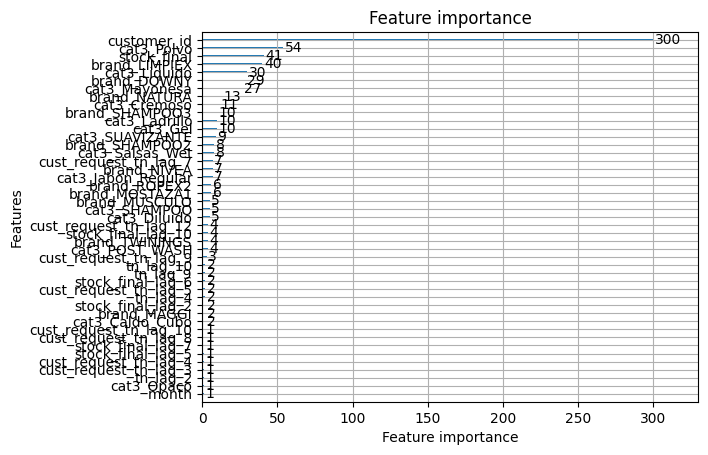

In [44]:


# Graficar importancia de características
lgb.plot_importance(model)
plt.show()

In [47]:
df_predictions.head(10)


,Actual,Predicted
periodo,,
2019-07,0.09255,0.007162
2019-07,0.02184,0.651250
2019-07,75.46739,166.603582
2019-07,36.23086,28.600762
2019-07,0.95185,2.591094
2019-07,0.00247,0.229741
2019-07,0.08980,1.709605
2019-07,0.38652,1.276415
2019-07,0.00561,1.022007
